In [110]:
import numpy as np
# import pandas as pd
from PIL import Image
import os
import time
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

Queremos minimizar la función de pérdida:

$$
\sum_{i=1}^{N} \left( f^*(\mathbf{i}_i) - d_i \right)^2
$$

Es decir, queremos minimizar la diferencia entre los diagnósticos que predice el modelo y los reales. 

Buscamos la mejor solución dentro de las funciones $f : \mathbb{R}^K \to (0, 1)$
 que tengan la forma:

$$
f_{\mathbf{w}, b}(\mathbf{i}) = \frac{\tanh(\mathbf{w} \cdot \mathbf{i} + b) + 1}{2}
$$


donde $w$ es un vector de pesos (weights) de $\mathbb{R}^K$ , $b$ (bias) un escalar, y $tanh$ la tangente hiperbólica.

## Preprocesamiento de imágenes

In [111]:
def image_convert(dir, new_size):
    
    imagenes = []

    for filename in os.listdir(dir):

        file_path = os.path.join(dir, filename)
        # print(f"Procesando imagen {file_path}")
        
        if os.path.isfile(file_path):

            # Sin este if no funciona en mi windows, probar comentarlo en Mac a ver que pasa
            if not filename.lower().endswith('.png'):
                continue

            try:
                with Image.open(file_path) as img:
                    img = img.resize(new_size) 
                    img = img.convert('L') # Convertir a escala de grises
                    img_array = np.array(img)/255.0 # Convertir a array y normalizar
                    img_vector = img_array.reshape((new_size[0]**2)) 
                    imagenes.append(img_vector)

            except Exception as e:
                print(f"Error procesando la imagen {file_path}: {e}")

    return np.array(imagenes)

Convertimos las imágenes a arreglos de pixeles y separamos en train y test

In [112]:
original = (256, 256)
mediano =  (128, 128)
chico = (64, 64)
muy_chico = (32, 32)

size = chico  

En el dataset provisto tenemos 1617 dibujos de pacientes sanos y 1629 dibujos de pacientes con parkinson.

Cómo armamos el conjunto de entrenamiento?
* Tiene que tener cantidades parecidas de pacientes con y sin parkinson.
* Aproximadamente el 70% del total de observaciones deberían ir al conjunto de entrenamiento

Podemos hacerlo asi: \
train \
sanos: 1132 \
enfermos: 1140 

test \
sanos: 485 \
enfermos: 489

In [113]:
cant_healthy_train = 1132
cant_park_train = 1140

cant_healthy_test = 485
cant_park_test = 489

In [114]:
# Convierto todas las imágenes a arreglos de pixeles según el tamaño elegido

# Healthy
src_dir = 'DatasetTP/Healthy'
i_healthy = image_convert(src_dir, size) # Imágenes de pacientes sanos
d_healthy = np.ones((i_healthy.shape[0], 1)) * 0 # Vector de diagnósticos para la gente sana (0)

# Parkinson
src_dir = 'DatasetTP/Parkinson'  
i_park = image_convert(src_dir, size) # Imágenes de pacientes con Parkinson
d_park = np.ones((i_park.shape[0], 1)) # Vector de diagnósticos para la gente con Parkinson (1)

# Separo en train y test
i_healthy_train = i_healthy[:cant_healthy_train]
d_healthy_train = d_healthy[:cant_healthy_train]

i_healthy_test = i_healthy[cant_healthy_train:cant_healthy_train + cant_healthy_test]
d_healthy_test = d_healthy[cant_healthy_train:cant_healthy_train + cant_healthy_test]

i_park_train = i_park[:cant_park_train]
d_park_train = d_park[:cant_park_train]

i_park_test = i_park[cant_park_train:cant_park_train + cant_park_test]
d_park_test = d_park[cant_park_train:cant_park_train + cant_park_test]

# Combino sanos y enfermos en train y test
i_train = np.vstack((i_healthy_train, i_park_train)) # Imágenes de entrenamiento
d_train = np.vstack((d_healthy_train, d_park_train)) # Diagnósticos de entrenamiento

i_test = np.vstack((i_healthy_test, i_park_test)) # Imágenes de test
d_test = np.vstack((d_healthy_test, d_park_test)) # Diagnósticos de test

print(i_train.shape, d_train.shape)
print(i_test.shape, d_test.shape)

# Mezclo los datos de entrenamiento y test
np.random.seed(42)  
indices = np.random.permutation(i_train.shape[0])
i_train = i_train[indices]
d_train = d_train[indices]

# Chequeamos que la intersección entre train y test sea nula (Importante)
print(len(set(map(tuple, i_train)).intersection(map(tuple, i_test))) == 0)


(1632, 4096) (1632, 1)
(0, 4096) (0, 1)
True


## Derivadas parciales

$$
\arg\min_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b) = 
\arg\min_{\mathbf{w}, b} \sum_{i=1}^{N} \left( f_{\mathbf{w}, b}(\mathbf{i}_i) - d_i \right)^2
$$


Derivamos $\mathcal{L}$ con respecto a $b$ (bias) y $w$ (weight):

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial w} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)\cdot i
$$

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial b} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)
$$

In [115]:
def fwb(i, w, b):
    z = i@w + b 
    f = np.tanh(z) / 2 
    return f # devuelve un vector

In [116]:
# Función a minimizar
def argminL(w, b, i, d):
    print(f"i.shape = {i.shape}")
    print(f"w.shape = {w.shape}")
    print(f"b.shape = {b.shape}")
    output = fwb(i, w, b)
    print(f"fwb output shape = {output.shape}")
    print(f"d.shape = {d.shape}")
    return np.sum((fwb(i, w, b) - d) ** 2) #suma todos los elementos del vector --> devuelve numero 

In [117]:
# Derivada parcial con respecto a w
# def df_w(w, b, i, d):
#     z = i @ w + b 
#     return (1 - np.tanh(z) ** 2) * ((1 + np.tanh(z)) / (2 - d)) @ i # Vector


def df_w(w, b, i, d):
    z = i @ w + b
    y_hat = (np.tanh(z) + 1) / 2
    dz = (1 - np.tanh(z) ** 2) * (y_hat - d)         # (1632, 1)
    grad_w = i.T @ dz / i.shape[0]                   # (4096, 1632) @ (1632, 1) → (4096, 1)
    return grad_w

In [118]:
# Derivada parcial con respecto a b
def df_b(w, b, i, d):
    z = i @ w + b
    y_hat = (np.tanh(z) + 1) / 2
    dz = (1 - np.tanh(z) ** 2) * (y_hat - d)         
    grad_w = i.T @ dz                
    return grad_w

## Gradiente Descendiente

In [119]:
# Máxima cantidad de iteraciones (previene loops infinitos)
MAX_ITER = 1000

# Criterio de convergencia (identifica un "plateau")
TOLERANCIA = 0.01

In [120]:
def gradiente_descendente(b, w, imagenes_train, diagnosticos_train, imagenes_test, diagnosticos_test, alpha=0.1):
    
    iter  = 0
    valores_train = []
    valores_test = []

    while iter <= MAX_ITER:
        print("Iteración: ", iter, "- Mínimo alcanzado hasta el momento: ", argminL(w, b, imagenes_train, diagnosticos_train))

        valores_train.append(argminL(w, b, imagenes_train, diagnosticos_train))

        if imagenes_test is not None and diagnosticos_test is not None: 
          valores_test.append(argminL(w, b, imagenes_test, diagnosticos_test))

        gradiente_w = df_w(w, b, imagenes_train, diagnosticos_train) 
        gradiente_b = df_b(w, b, imagenes_train, diagnosticos_train)
        # print("gradiente_w.shape:", gradiente_w.shape)
        # print("gradiente_b.shape:", gradiente_b.shape)
        # print("b.shape:", b.shape)
        # Si gradiente_b no es escalar, colapsar con promedio o suma
        if gradiente_b.ndim > 0 and gradiente_b.size > 1:
          gradiente_b = np.mean(gradiente_b)  # O np.sum(gradiente_b)

        w_sig = w - alpha * gradiente_w
        b_sig = b - alpha * gradiente_b

        criterio = np.abs(argminL(w_sig, b_sig, imagenes_train, diagnosticos_train) - argminL(w, b, imagenes_train, diagnosticos_train))

        if criterio < TOLERANCIA: # Converge
          break

        w = w_sig
        b = b_sig
        iter += 1

    return w_sig, b_sig, valores_train, valores_test

i.shape = (1632, 4096)
w.shape = (4096, 1)
b.shape = (1, 1)
fwb output shape = (1632, 1)
d.shape = (1632, 1)
Iteración:  0 - Mínimo alcanzado hasta el momento:  816.0
i.shape = (1632, 4096)
w.shape = (4096, 1)
b.shape = (1, 1)
fwb output shape = (1632, 1)
d.shape = (1632, 1)
i.shape = (0, 4096)
w.shape = (4096, 1)
b.shape = (1, 1)
fwb output shape = (0, 1)
d.shape = (0, 1)
i.shape = (1632, 4096)
w.shape = (4096, 1)
b.shape = (1, 1)
fwb output shape = (1632, 1)
d.shape = (1632, 1)
i.shape = (1632, 4096)
w.shape = (4096, 1)
b.shape = (1, 1)
fwb output shape = (1632, 1)
d.shape = (1632, 1)
i.shape = (1632, 4096)
w.shape = (4096, 1)
b.shape = (1, 1)
fwb output shape = (1632, 1)
d.shape = (1632, 1)
Iteración:  1 - Mínimo alcanzado hasta el momento:  854.9747035734279
i.shape = (1632, 4096)
w.shape = (4096, 1)
b.shape = (1, 1)
fwb output shape = (1632, 1)
d.shape = (1632, 1)
i.shape = (0, 4096)
w.shape = (4096, 1)
b.shape = (1, 1)
fwb output shape = (0, 1)
d.shape = (0, 1)
i.shape = (1632, 4

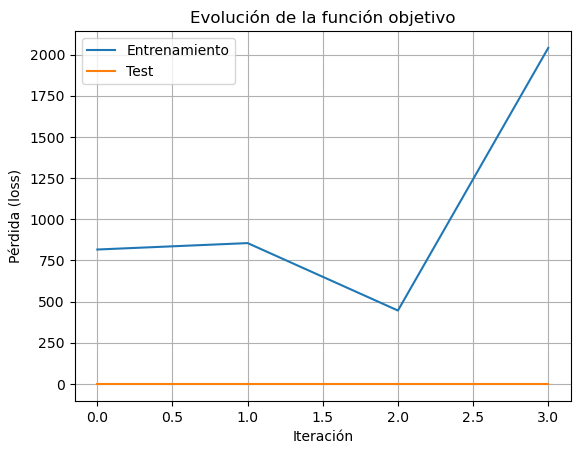

In [121]:
w, b, valores_train, valores_test = gradiente_descendente(
    b=np.zeros((1, 1)), 
    w=np.zeros((i_train.shape[1], 1)), 
    imagenes_train=i_train, 
    diagnosticos_train=d_train, 
    imagenes_test=i_test, 
    diagnosticos_test=d_test, 
    alpha=0.01
)

plt.plot(valores_train, label="Entrenamiento")
plt.plot(valores_test, label="Test")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la función objetivo")
plt.legend()
plt.grid(True)
plt.show()